# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

In [1]:
import time
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss as CEL
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [2]:
start_token = '<BoS>'
end_token = '<EoS>'

dataset = LanguageDataset(data_path="Data/eng_ita.tsv", start_token = start_token, end_token = end_token)
train_set, val_set, test_set = dataset.get_datasets()

embedding_size = 256

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

trainloader = DataLoader(train_set, batch_size = 100)

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))

English vocabulary size for training: 2548
Italian vocabulary size for training: 3885


EPOCH 1: train loss =  3.286
EPOCH 2: train loss =  2.367
EPOCH 3: train loss =  2.247
EPOCH 4: train loss =  2.181
EPOCH 5: train loss =  2.138
EPOCH 6: train loss =  2.111
EPOCH 7: train loss =  2.091
EPOCH 8: train loss =  2.086
EPOCH 9: train loss =  2.02
EPOCH 10: train loss =  1.985
--------------------------------
Time required: 114.30564403533936


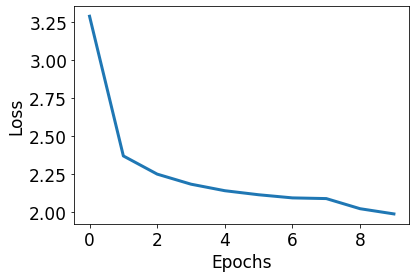

In [3]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters()), 
                 decoder_optimizer = Adam(decoder.parameters()),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

start_time = time.time()
L = model.train_model(trainloader, 
                  max_epochs = 10,
                  save_every_epochs = 20,
                  ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L, linewidth = 3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");

## Training

In [4]:
testloader = DataLoader(test_set, batch_size = 100)

X, y, trans = model.evaluate_model(testloader, max_length=20)#, enc_ckp = "test_enc_20.pth", dec_ckp="test_dec_20.pth")

In [8]:
ids = 34
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> Why is life so full of suffering <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Italian:  <BoS> Perché la vita è così piena di sofferenza <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Translation:  <BoS> Il è è è di <EoS> <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


In [9]:
ids = 12
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> Aren t you happy <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Italian:  <BoS> Lei non è felice <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Translation:  <BoS> Non è <EoS> <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


In [10]:
ids = 67
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> Are you feeling sick <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Italian:  <BoS> Vi sentite male <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Translation:  <BoS> Non è <EoS> <EoS> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
